In [1]:
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sympy import *
from matplotlib import animation
from JSAnimation.IPython_display import display_animation
from control import * 

%matplotlib inline

# Comment out in Google colab 
init_printing(use_latex='mathjax')

# Uncomment in below Google colab to render sympy equations nicely
# def custom_latex_printer(exp,**options):
#     from google.colab.output._publish import javascript
#     url = "https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/latest.js?config=default"
#     javascript(url=url)
#     return printing.latex(exp,**options)
# init_printing(use_latex="mathjax",latex_printer=custom_latex_printer)

def chop(A, eps = 1e-10):
	B = np.copy(A)
	B[np.abs(A) < eps] = 0
	return B

In [6]:
def show_sim(tvals,X,title):
    
    fig,ax = plt.subplots(1,3,figsize=(15,5))

    plots = ax[0].plot(tvals,X[:,0],tvals,X[:,1]);
    ax[0].legend(plots, ["$x$", "$v$" ]);
    ax[0].set_xlabel("$t$")
    ax[0].set_title(title + "\nPosition / Velocity");

    plots = ax[1].plot(tvals,X[:,2],tvals,X[:,3]);
    ax[1].legend(plots, ["$q$", "$w$" ]);
    ax[1].set_xlabel("$t$")
    ax[1].set_title(title + "\nAngle / Angular Velocity");

    ax[2].plot(tvals,X[:,0]+10*np.sin(X[:,2]));
    ax[2].set_title(title + "\nLoad Position")
    ax[2].set_xlabel("$t$")
    ax[2].set_ylabel("$x(t)$");
    
    return fig, ax

def anim(X,title):
    
    # This function is only here so that all the variables below are local to it and
    # we don't overwrite them as defined above.
    
    x = X[:,0][0]
    q = X[:,2][0]
    l = 10

    xl = x+l*sin(q)
    yl = -l*cos(q)

    fig,ax = plt.subplots(1)

    beam, = ax.plot([x,xl],[0,yl])
    rail, = ax.plot([0,40],[0,0])
    cart = patches.Rectangle((x-1,-1), 2,2)
    load = patches.Circle((xl,yl), 1)

    ax.add_patch(cart)
    ax.add_patch(load)
    ax.set_xlim(0,40)
    ax.set_ylim(-15,5)
    ax.set_aspect(1)
    ax.set_title(title)

    num_frames = len(X)

    def animate(f):
        x = X[:,0][f]
        q = X[:,2][f] 
        xl = x+l*sin(q)
        yl = -l*cos(q)
        cart.set_xy((x-1,-1))
        load.set_center((xl,yl))
        beam.set_data([x,xl],[0,yl])
        return [cart,load,beam]

    anim = animation.FuncAnimation(fig, animate, frames=num_frames, interval=80)
    return display_animation(anim, default_mode='loop')

In [167]:
class Crane:
    
    def __init__(self,update_function=None,parameters=None,X0=None):
        
        self.update_function = update_function
        
        if not parameters:
            self.params = [
                (m1,1), (m2,0.1), (L,10), (k1,2), (k2,0.1), (g,9.81)
            ]
        else:
            self.params = paramsters
            
        if not X0:
            self.X0=[15,0,0,0]
        else:
            self.X0 = X0
            
        if not update_function:
            update_function = lambda c : 0            

        self.setup()
        self.clear()
        
    def clear(self):
        self.X = self.X0
        self.t = 0        
        self.Xdata = np.array([])
        self.udata = np.array([])
        self.tdata = np.array([])        
        return self;
        
    def setup(self):
        
        print("Setting up energies")
        var("m g L x theta t m1 m2 k1 k2 u v omega q w uu")
        xdot = diff(x(t),t)
        xddot = diff(xdot,t)
        xdddot = diff(xddot,t)
        thetadot = diff(theta(t),t)
        thetaddot = diff(thetadot,t)
        thetadddot = diff(thetaddot,t)

        U = m2*g*(L-L*cos(theta(t)))

        K = (1/2)*m1*diff(x(t),t)**2/2 +(1/2)*m2*(
              diff(x(t)+L*sin(theta(t)),t)**2 +
              diff((-L*cos(theta(t))),t)**2
            )

        print("Simplifying kinetic energy")
        K = K.simplify()   
        
        print("Compiting lagranians")
        eq1 = diff(diff(Lagrangian,xdot),t)-diff(Lagrangian,x(t)) + k1*xdot - u
        eq2 = diff(diff(Lagrangian,thetadot),t)-diff(Lagrangian,theta(t)) + k2*thetadot  
        
        print("Solving for the state")
        sol = solve([eq1,eq2],[xddot,thetaddot])
        
        print("Defining dynamics function")
        sub = [            
            (xdot,v),    
            (x(t),x),
            (thetadot,w),
            (theta(t),q),
        ]
        dv = sol[xddot].subs(sub)
        dw = sol[thetaddot].subs(sub)
        
        self.dynamics = lambdify([x,v,q,w,uu], [
            v, 
            dv.subs(self.params).subs(u,uu),
            w,
            dw.subs(self.params).subs(u,uu)
        ])
        
        print("Setup complete") 
        
    def get_param(self,s):
        i = 0
        while self.params[i][0] != s:
            i += 1
        return self.params[i][1]
        
    def set_update(self,upf):
        self.update_function = upf
        return self
        
    def make_f(self,u):
        def f(X,t):
            x,v,q,w = X
            return self.dynamics(x,v,q,w,u)
        return f
        
    def get_time(self):
        return self.t
    
    def get_state(self):
        return self.X
    
    def get_sensor_value(self):
        return self.X[0] + self.get_param(L) * np.sin(self.X[2])
        
    def run(self, dt=0.1, tmax=10):
        self.clear()
        while self.t < tmax:
            u = self.update_function(self)
            tvals = np.linspace(self.t, self.t+dt,20)
            Xtraj = spi.odeint(self.make_f(u),self.X,tvals)
            
            self.udata = np.append(self.udata,u*np.ones(20))
            self.tdata = np.append(self.tdata,tvals)
            
            if len(self.Xdata) == 0:
                self.Xdata = Xtraj
            else:
                self.Xdata = np.concatenate([self.Xdata,Xtraj])
                
            self.X = Xtraj[-1]
            self.t += dt                
            
        return self.tdata, self.udata, self.Xdata        

In [168]:
c = Crane()

Setting up energies
Simplifying kinetic energy
Compiting lagranians
Solving for the state
Defining dynamics function
Setup complete


In [180]:
# START CODE THAT LOOKS LIKE WHAT YOU'D SEE ON A MICROCONTROLLER
########################################################################

def update(crane):
    return 0.1*(30-crane.get_sensor_value())

########################################################################
# END PSEUDO-MICROCONTROLLER CODE

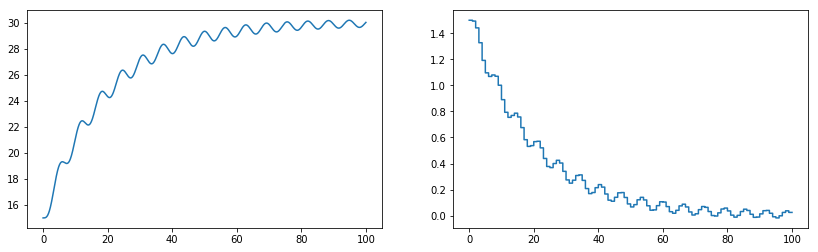

In [179]:
# Simulate

c.set_update(update)
t,u,X = c.run(dt=1,tmax=100)

fig,ax = plt.subplots(1,2,figsize=(14,4))
ax[0].plot(t,X[:,0] + 10*np.sin(X[:,2]));
ax[1].step(t,u);